### <font color="#0000dd"> 1.要求动手从0实现softmax回归（只借助Tensor和Numpy相关的库）在Fashion-MNIST数据集上进行训练和测试，并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析。</font><br />
#### <font color="#dd0000">要求从零实现交叉熵损失函数</font><br />

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

#### 读取数据

* 加载数据

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=True,
                                                download=True,transform=transforms.ToTensor())

mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=False,
                                                download=True,transform=transforms.ToTensor())

batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False)

* 数据预览

In [3]:
label_name=['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
            'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [4]:
import matplotlib.pyplot as plt

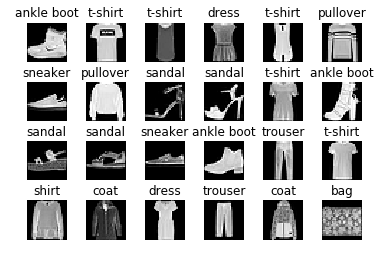

In [5]:
for i in range(24):
    feature, label = mnist_train[i]
    plt.subplot(4,6,i+1)
    plt.axis('off')
    plt.title(label_name[label])
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    plt.imshow(feature[0,:,:],cmap ='gray')
plt.savefig('Fashion-MNIST.jpg')

#### 构建模型

* 初始化模型参数

图片的大小为28×28，共有10个类别  
softmax回归的权重和偏差参数分别为 784×10 和 1×10 的矩阵。

In [6]:
num_inputs = 784
num_outputs = 10

w = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)),dtype=torch.float32)
b = torch.zeros(1,num_outputs,dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)

* 定义模型

In [7]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

def Softmax_Reg(x,w,b):
    return softmax(torch.mm(x.reshape(-1, num_inputs),w)+b)

#### 定义损失函数和优化算法

* 损失函数（交叉熵损失函数）

In [8]:
def CrossEntropyLoss(y_hat,y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

* 优化算法（随机梯度下降）

In [9]:
def sgd(params, lr, batch_size):  
    for param in params:
        param.data -= lr * param.grad / batch_size 

#### 模型训练

In [10]:
lr = 0.03
num_epochs = 10
net = Softmax_Reg
loss = CrossEntropyLoss
train_acc=[]
train_loss=[]
for epoch in range(num_epochs):
    train_l = 0
    total = 0
    correct =0
    for X,y in train_iter:
        output = net(X,w,b)
        _,pre = torch.max(output.data,1)
        correct += (pre==y.squeeze()).sum()
        l = loss(output,y).sum()
        l.backward()
        sgd([w,b],lr,batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_() 
        train_l += l
        total += y.shape[0]
    train_l = train_l/total
    acc = torch.div(float(correct),total)
    train_acc.append(acc)
    train_loss.append(train_l)
    print(('epoch %d,loss: %f,acc: %f')%(epoch,train_l,acc))

epoch 0,loss: 1.032819,acc: 0.696083
epoch 1,loss: 0.709032,acc: 0.778017
epoch 2,loss: 0.637114,acc: 0.798100
epoch 3,loss: 0.597702,acc: 0.808533
epoch 4,loss: 0.571975,acc: 0.815133
epoch 5,loss: 0.553057,acc: 0.820567
epoch 6,loss: 0.538859,acc: 0.824250
epoch 7,loss: 0.527393,acc: 0.827783
epoch 8,loss: 0.517773,acc: 0.830050
epoch 9,loss: 0.509719,acc: 0.832017


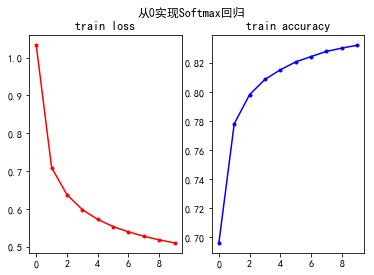

In [11]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

plt.subplot(1,2,1)
plt.plot(range(10),train_loss,'r.-')
plt.title('train loss')
plt.subplot(1,2,2)
plt.plot(range(10),train_acc,'b.-')
plt.title('train accuracy')
plt.suptitle('从0实现Softmax回归')
plt.savefig('0_loss_acc.jpg')

**模型测试**

In [12]:
test_l = 0
total = 0
correct =0
for X,y in test_iter:
    output = net(X,w,b)
    _,pre = torch.max(output.data,1)
    correct += (pre==y.squeeze()).sum()
    l = loss(output,y).sum()
    test_l += l
    total += y.shape[0]
test_l = test_l/total
acc = torch.div(float(correct),total)
print(('loss: %f,acc: %f')%(test_l,acc))

loss: 0.533744,acc: 0.820200


### <font color="#0000dd"> 2.利用torch.nn实现softmax回归在Fashion-MNIST数据集上进行训练和测试，并从loss,训练集以及测试集上的准确率多个角度对结果进行分析</font><br />

In [13]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.nn import init
import torch.optim as optim

**构建模型**

* 定义模型

In [24]:
class softmax_reg(nn.Module):
    def __init__(self,num_inputs,num_outputs):
        super(softmax_reg,self).__init__()
        self.lr = nn.Linear(num_inputs,num_outputs)
    
    def forward(self,x):
        x = self.lr(x)
        return x
    
num_inputs = 784
num_outputs = 10   
net = softmax_reg(num_inputs,num_outputs)

**定义损失和优化方法**

In [25]:
# 交叉熵损失函数
Loss = nn.CrossEntropyLoss()

# 随机梯度下降的优化方法
optimizer = optim.SGD(net.parameters(),lr=0.03)

**模型训练**

In [26]:
num_epochs = 10
acc=[]
train_loss=[]
train_acc=[]
for epoch in range(1,num_epochs+1):
    train_l = 0
    total = 0
    correct = 0
    for X,y in train_iter:
        X = X.reshape(-1,num_inputs)
        output = net(X)
        _,predicted = torch.max(output.data,1)
        total += y.size(0)
        correct += (predicted==y.squeeze()).sum()
        l = Loss(output,y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_l += l
    train_l = train_l/len(train_iter)
    acc =torch.div(float(correct),total)
    train_loss.append(train_l)
    train_acc.append(acc)
    print(('epoch %d,loss: %f,acc: %f')%(epoch,train_l,acc))

epoch 1,loss: 1.033738,acc: 0.694883
epoch 2,loss: 0.710454,acc: 0.777100
epoch 3,loss: 0.638503,acc: 0.797517
epoch 4,loss: 0.598822,acc: 0.808267
epoch 5,loss: 0.572293,acc: 0.815433
epoch 6,loss: 0.553849,acc: 0.819750
epoch 7,loss: 0.539650,acc: 0.823367
epoch 8,loss: 0.527652,acc: 0.827000
epoch 9,loss: 0.517959,acc: 0.829167
epoch 10,loss: 0.510692,acc: 0.831350


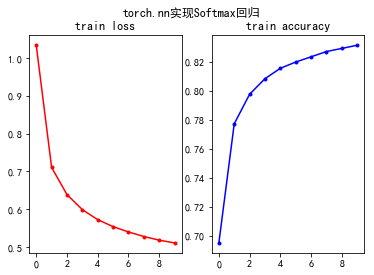

In [27]:
plt.subplot(1,2,1)
plt.plot(range(10),train_loss,'r.-')
plt.title('train loss')
plt.subplot(1,2,2)
plt.plot(range(10),train_acc,'b.-')
plt.title('train accuracy')
plt.suptitle('torch.nn实现Softmax回归')
plt.savefig('loss_acc.jpg')

**模型测试**

In [30]:
train_l = 0
total = 0
correct = 0
for X,y in test_iter:
    X = X.reshape(-1,num_inputs)
    output = net(X)
    _,predicted = torch.max(output.data,1)
    total += y.size(0)
    correct += (predicted==y.squeeze()).sum()
    l = Loss(output,y)
    train_l += l
train_l = train_l/len(train_iter)
acc =torch.div(float(correct),total)
print(('loss: %f,acc: %f')%(train_l,acc))

loss: 0.090073,acc: 0.819900
